In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#!pip install jupyterthemes
!jt -t onedork -f fira -fs 12 -nf ptsans -nfs 12 -N -kl -cursw 5 -cursc r -cellw 95% -T
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

## Nomenclature
- Complete data collection procedure, from init to writing is referred to as a "run".   
- Each step in a run is an "event".  
- Where a run is in the sequence of events is it's "state"
- To move between states requires "triggers"

## States are
* waiting: in between events; triggered by conclusion of steps.  Options while waiting include
    * set parameters (wavelength/steps, integration time, devices to include in the initialization, compression?, write results?, display in real time?)
    * initialize
    * run all
* initializing (complete and between runs): triggered by initialize command (at any time, but warning if initialize already happened) will initialize all devices with checked boxes in GUI. Returns dictionary of device metadata
* collecting: triggered by collection command (at end sets self.data_in_queue = True)
* compressing: triggered by compression commmand (at end sets self.data_ready_to_store = True) 
* writing: triggered by writing command
* fubar: triggered by an error in any of the steps
* interupt: is this a state or a command?  

# GUI Developement

In [3]:
import os
import sys
import pdb
import numpy as np
import copy
from math import *
import datetime as datetime

sys.path.append(r'..\pylab\pylabsm')
sys.path.append(r'..\pylab\pylabcal\pylabcald')

from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *

from pylabsm import SpectralCalibrationMachine

from matplotlib import pyplot as plt

class cal_gui_tab(QTabWidget):
    def __init__(self, parent = None, config_file='setup.cfg'):
        super(cal_gui_tab, self).__init__(parent)
        
        self.state_machine = SpectralCalibrationMachine(config_file=config_file)
        self.parameters_default = copy.deepcopy(self.state_machine.params)
        #self.parameters_last = copy.deepcopy(self.state_machine.params)
        #self.parameters = copy.deepcopy(self.state_machine.params)
        
        self.tab1 = QWidget()
        self.tab2 = QWidget()
        self.tab3 = QWidget()

        self.addTab(self.tab1,"Main")
        self.addTab(self.tab2,"Settings")
        self.addTab(self.tab3,"Metadata")
        self.tab1UI()
        self.tab2UI()
        self.tab3UI()
        self.setWindowTitle("Spectral Calibration Interface")
        
        self.retranslateUi()
        
    def tab1UI(self):
        layout = QGridLayout()
        self.setTabText(0,"Run")
        
        # Initialize Button
        self.initialize_button = QPushButton(self)
        self.initialize_button.setText("Initialize")
        layout.addWidget(self.initialize_button, 0, 0)

        # Start Run Button
        self.start_run_button = QPushButton(self)
        self.start_run_button.setText("Start Run")
        layout.addWidget(self.start_run_button, 1, 0)
        
        # Automate Check Box (default is checked)
        self.automate_box = QCheckBox(self)
        self.automate_box.setText("Use .cfg")
        #self.automate_box.stateChanged.connect(self.automate_button_clicked) 
        layout.addWidget(self.automate_box, 1, 1)
        self.automate_box.setChecked(True)
        
        # Config File
        # Temporary Storage Directory
        #layout_config = QHBoxLayout()
        label_config = QLabel("Config File: ")
        #layout_config.addWidget(label_config)
        cfg_file = self.state_machine.cfg_file_default 
        self.cfg_file_ui = QLineEdit(cfg_file)
        self.cfg_file_ui.selectAll()
        self.cfg_file_ui.textChanged.connect(self.sync_config_file)
        #layout_config.addWidget(self.cfg_file_ui)   
        layout.addWidget(label_config,2,0)
        layout.addWidget(self.cfg_file_ui,2,1)
        
        # Event progress bar
        self.progress = QProgressBar(self)
        layout.addWidget(self.progress, 3, 0, 1, 2)
        
        # Full run progress bar
        self.progress = QProgressBar(self)
        layout.addWidget(self.progress, 4, 0, 1, 2)
        
        # Launch Motor Window
        self.motor_button = QPushButton(self)
        self.motor_button.setText("Open Motor Window")
        layout.addWidget(self.motor_button, 5, 0, 1, 2)
        
        # Message box
        self.msg = QTextBrowser()
        layout.addWidget(self.msg, 0, 2, 6, 4)
        
        # Populate Tab 1
        self.tab1.setLayout(layout)
        
    def tab2UI(self):
        layout = QFormLayout()
        self.setTabText(1,"Settings")       

        # Monochrometer Wavelengths
        layout2 = QGridLayout()
        label = QLabel("Wavelengths: ")
        label_0 = QLabel("Monochrometer")
        label_l = QLabel("Start ")
        label_m = QLabel("End ")
        label_r = QLabel("Step ")
        layout2.addWidget(label_0, 1, 0)
        layout2.addWidget(label_l, 1, 1)
        layout2.addWidget(label_m, 1, 2)
        layout2.addWidget(label_r, 1, 3)
        
        wavelength_start = int(self.state_machine.params['monochrometer']['wavelength_start'])
        wavelength_stop = int(self.state_machine.params['monochrometer']['wavelength_stop'])
        wavelength_step = int(self.state_machine.params['monochrometer']['wavelength_step'])
        
        self.wavelength0 = QSpinBox(self)
        self.wavelength0.setMinimum(wavelength_start)
        self.wavelength0.setMaximum(wavelength_stop)
        self.wavelength0.setValue(wavelength_start)
        self.wavelength0.valueChanged.connect(self.updateStartWavelength)
        
        self.wavelength1 = QSpinBox(self)
        self.wavelength1.setMinimum(wavelength_start)
        self.wavelength1.setMaximum(wavelength_stop)
        self.wavelength1.setValue(wavelength_stop) 
        self.wavelength1.valueChanged.connect(self.updateStopWavelength)
        
        self.wavelength2 = QSpinBox(self)
        self.wavelength2.setMinimum(1)
        self.wavelength2.setMaximum(200)
        self.wavelength2.setValue(wavelength_step) 
        self.wavelength2.valueChanged.connect(self.updateStepWavelength)

        layout2.addWidget(label, 2, 0)
        layout2.addWidget(self.wavelength0, 2, 1)
        layout2.addWidget(self.wavelength1, 2, 2)
        layout2.addWidget(self.wavelength2, 2, 3)

        # Add wavelengths Row
        layout.addRow(layout2)
        
        # Temporary Storage Directory
        layout_temp_dir = QHBoxLayout()
        label_temp_dir = QLabel("Temporary Storage Path: ")
        layout_temp_dir.addWidget(label_temp_dir)
        cfg_temp_dir = self.state_machine.params['io']['temp_storage_folder']
        self.temp_dir = QLineEdit(cfg_temp_dir)
        self.temp_dir.selectAll()
        self.temp_dir.textChanged.connect(self.sync_temp_storage_path)
        layout_temp_dir.addWidget(self.temp_dir)   
        layout.addRow(layout_temp_dir)
        
        # Final Storage Path
        layout_final_dir = QHBoxLayout()
        label_final_dir = QLabel("Permanent Storage Path: ")
        layout_final_dir.addWidget(label_final_dir)
        cfg_final_dir = self.state_machine.params['io']['permanent_storage_folder']
        self.final_dir = QLineEdit(cfg_final_dir)
        self.final_dir.selectAll()
        self.final_dir.textChanged.connect(self.sync_final_storage_path)
        layout_final_dir.addWidget(self.final_dir)   
        layout.addRow(layout_final_dir)
        
        # Suffix Name
        layout_suffix = QHBoxLayout()
        label_suffix = QLabel("Filename Suffix: ")
        layout_suffix.addWidget(label_suffix)
        cfg_suffix = self.state_machine.params['io']['suffix']
        if cfg_suffix == "date":
            cfg_suffix = self.get_datetime_now()
        self.suffix = QLineEdit(cfg_suffix)
        self.suffix.selectAll()
        layout_suffix.addWidget(self.suffix)   
        layout.addRow(layout_suffix)
        
        # Data Format Type 
        layout3 = QGridLayout()
        label_write = QLabel("Data Format: ")
        self.csv_box = QCheckBox(self)
        self.csv_box.setText(".csv")
        self.json_box = QCheckBox(self)
        self.json_box.setText(".json")
        self.parquet_box = QCheckBox(self)
        self.parquet_box.setText(".parquet")
        layout3.addWidget(label_write, 0, 0)
        layout3.addWidget(self.csv_box, 0, 1)
        layout3.addWidget(self.json_box, 0, 2)
        layout3.addWidget(self.parquet_box, 0, 3)
        self.parquet_box.setChecked(self.pick_format('io','storage_type',".parquet"))
        self.csv_box.setChecked(self.pick_format('io','storage_type',".csv"))
        self.json_box.setChecked(self.pick_format('io','storage_type',".json"))
        # calling the uncheck method if any check box state is changed 
        self.csv_box.stateChanged.connect(self.uncheck_write) 
        self.json_box.stateChanged.connect(self.uncheck_write) 
        self.parquet_box.stateChanged.connect(self.uncheck_write) 
        layout.addRow(layout3)
        
        # Compression Type 
        layout4 = QGridLayout()
        label_comp = QLabel("Compression: ")
        self.zip_box = QCheckBox(self)
        self.zip_box.setText(".zip")
        self.tgz_box = QCheckBox(self)
        self.tgz_box.setText(".tgz")
        self.tar_box = QCheckBox(self)
        self.tar_box.setText(".tar")
        layout4.addWidget(label_comp, 0, 0)
        layout4.addWidget(self.zip_box, 0, 1)
        layout4.addWidget(self.tgz_box, 0, 2)
        layout4.addWidget(self.tar_box, 0, 3)
        self.zip_box.setChecked(self.pick_format('io','compression_type',".zip"))
        self.tgz_box.setChecked(self.pick_format('io','compression_type',".tgz"))
        self.tar_box.setChecked(self.pick_format('io','compression_type',".tar"))
        # calling the uncheck method if any check box state is changed 
        self.zip_box.stateChanged.connect(self.uncheck_comp) 
        self.tar_box.stateChanged.connect(self.uncheck_comp) 
        self.tgz_box.stateChanged.connect(self.uncheck_comp) 
        layout.addRow(layout4)
        
        # Populate Tab 2
        self.tab2.setLayout(layout)
                
    def tab3UI(self):
        layout = QVBoxLayout()
        self.setTabText(2,"Metadata")
        
        # Metadata Checkboxes
        layout.addWidget(QLabel("Metadata to Include")) 
        self.cryo_temperature = QCheckBox("Cryo_Temperature")
        layout.addWidget(self.cryo_temperature)
        self.cryo_temperature.setChecked(self.pick_format('metadata','cryo_temperature',"True"))
        self.power_meter = QCheckBox("Power_Meter")
        layout.addWidget(self.power_meter)
        self.power_meter.setChecked(self.pick_format('metadata','power_meter',"True"))
        self.filter_wheel_1 = QCheckBox("Filter_Wheel_1")
        layout.addWidget(self.filter_wheel_1)
        self.filter_wheel_1.setChecked(self.pick_format('metadata','filter_wheel_1',"True"))
        self.filter_wheel_2 = QCheckBox("Filter_Wheel_2")
        layout.addWidget(self.filter_wheel_2)
        self.filter_wheel_2.setChecked(self.pick_format('metadata','filter_wheel_2',"True"))
        self.encoder_1 = QCheckBox("Encoder_1")
        layout.addWidget(self.encoder_1)
        self.encoder_1.setChecked(self.pick_format('metadata','encoder_1',"True"))
        self.encoder_2 = QCheckBox("Encoder_2")
        layout.addWidget(self.encoder_2)
        self.encoder_2.setChecked(self.pick_format('metadata','encoder_2',"True"))
        
        # Keywords
        label_keywords = QLabel("Search Keywords: ")
        layout.addWidget(label_keywords)
        cfg_keywords = cfg_final_dir = self.state_machine.params['io']['keywords']
        self.keywords = QLineEdit(cfg_keywords)
        #self.keywords.selectAll()
        #self.keywords.returnPressed(self.update_config_io("keywords"))
        layout.addWidget(self.keywords)
        
        # Populate Tab 3
        self.tab3.setLayout(layout)

    def retranslateUi(self):
        
        self.initialize_button.clicked.connect(self.initialize_button_clicked)
        self.motor_button.clicked.connect(self.motor_button_clicked)
        self.start_run_button.clicked.connect(self.start_run_button_clicked)

        self.dialogTextBrowser = motorWindow(self)
        #pdb.set_trace()
        if len(self.state_machine.message_box) > 0:
            for i in self.state_machine.message_box:
                last_line = self.state_machine.message_box.pop()
                self.msg.append(last_line)
    
    @pyqtSlot()
    def motor_button_clicked(self):
        tst = self.dialogTextBrowser.exec_()
    
    def sync_config_file(self):
        self.state_machine.cfg_file_default = self.cfg_file_ui.text()
        
    def sync_temp_storage_path(self):
        self.state_machine.params['io']['temp_storage_folder'] = self.temp_dir.text()
    
    def sync_final_storage_path(self):
        self.state_machine.params['io']['permanent_storage_folder'] = self.final_dir.text()
                
    def initialize_button_clicked(self):
        self.state_machine = SpectralCalibrationMachine()
        self.display_messages_in_box()
    
    def update_config_io(self, values):
        pdb.set_trace()
        self.state_machine.params['io']['keywords'] = values
        #self.automate_box.setChecked(False)
        self.check_default_changed()
        
        msg_txt = 'Keywords Changed to %s' % values
        self.state_machine.message_box.append(msg_txt)
        self.display_messages_in_box()
        
    def updateStartWavelength(self, values):
        self.state_machine.params['monochrometer']['wavelength_start'] = values
        #self.automate_box.setChecked(False)
        self.check_default_changed()
        
        msg_txt = 'Starting Wavelength Changed to %4i' % values
        self.state_machine.message_box.append(msg_txt)
        self.display_messages_in_box()
        
    def updateStopWavelength(self, values):
        self.state_machine.params['monochrometer']['wavelength_stop'] = values
        #self.automate_box.setChecked(False)
        self.check_default_changed()
        
        msg_txt = 'Ending Wavelength Changed to %4i' % values
        self.state_machine.message_box.append(msg_txt)
        self.display_messages_in_box()
        
    def updateStepWavelength(self, values):
        self.state_machine.params['monochrometer']['wavelength_step'] = values
        #self.automate_box.setChecked(False)
        self.check_default_changed()
        
        msg_txt = 'Step Wavelength Changed to %4i' % values
        self.state_machine.message_box.append(msg_txt)
        self.display_messages_in_box()
        
    def start_run_button_clicked(self):
        
        self.state_machine.transduce([{'initialize': [0,2,4]},{'collect': [0,2,4]},{'compress': [0,2,4]},{'write_to_disk': [0,2,4]}])
        self.display_messages_in_box()

    def automate_button_clicked(self):
        if self.automate_box.setChecked(True):
            self.state_machine.params = copy.deepcopy(self.parameters_default)
        
        msg_txt = 'Reset to Default Parameters'
        self.state_machine.message_box.append(msg_txt)
        self.display_messages_in_box()
        
    def progress_bar_estimator(self):
        
        self.completed = 0

        while self.completed < 100:
            self.completed += 0.0001
            self.progress.setValue(self.completed)
            
    def display_messages_in_box(self):

        while len(self.state_machine.message_box) > 0 :
            last_line = self.get_time_now() + self.state_machine.message_box.pop(0)
            self.state_machine.message_log.append(last_line)
            self.msg.append(last_line)
    
    def get_datetime_now(self):
        dateTimeObj = datetime.datetime.now()
        return dateTimeObj.strftime("_%d%m%Y_%H%M")
    
    def get_time_now(self):
        dateTimeObj = datetime.datetime.now()
        #return "_" + dateTimeObj.strftime("%H:%M:%S")
        return dateTimeObj.strftime("%H:%M:%S") + " "

    def pick_format(self, format_level, format_type, format_in):
        return self.state_machine.params[format_level][format_type].lower() == format_in.lower()
    
    def check_default_changed(self):
        self.automate_box.setChecked(True)
        for ikey0 in self.state_machine.params:
            for ikey1 in self.state_machine.params[ikey0]:
                if (self.state_machine.params[ikey0][ikey1] == self.parameters_default[ikey0][ikey1]) == False:
                    self.automate_box.setChecked(False)
                    #pdb.set_trace()
                    break
            
    # uncheck method 
    def uncheck_comp(self, state):
        #self.automate_box.setChecked(False)
        self.check_default_changed()
  
        # checking if state is checked 
        if state == Qt.Checked: 
  
            # if first check box is selected 
            if self.sender() == self.zip_box:
            
                self.state_machine.params['io']['compression_type'] = '.zip'
                msg_txt = 'Compression type changed to .zip'
                self.state_machine.message_box.append(msg_txt)
                self.display_messages_in_box()
                
                # making other check box to uncheck 
                self.tgz_box.setChecked(False) 
                self.tar_box.setChecked(False) 
  
            # if second check box is selected 
            elif self.sender() == self.tar_box: 
  
                self.state_machine.params['io']['compression_type'] = '.tar'
                msg_txt = 'Compression type changed to .tar'
                self.state_machine.message_box.append(msg_txt)
                self.display_messages_in_box()
                
                # making other check box to uncheck 
                self.zip_box.setChecked(False) 
                self.tgz_box.setChecked(False) 
  
            # if third check box is selected 
            elif self.sender() == self.tgz_box: 
  
                self.state_machine.params['io']['compression_type'] = '.tgz'
                msg_txt = 'Compression type changed to .tgz'
                self.state_machine.message_box.append(msg_txt)
                self.display_messages_in_box()
                
                # making other check box to uncheck 
                self.zip_box.setChecked(False) 
                self.tar_box.setChecked(False) 
            
    # uncheck method 
    def uncheck_write(self, state):
        self.automate_box.setChecked(False)
  
        # checking if state is checked 
        if state == Qt.Checked: 
  
            # if first check box is selected 
            if self.sender() == self.csv_box: 
  
                self.state_machine.params['io']['storage_type'] = '.csv'
                msg_txt = 'Storage type changed to .csv'
                self.state_machine.message_box.append(msg_txt)
                self.display_messages_in_box()
                
                # making other check box to uncheck 
                self.json_box.setChecked(False) 
                self.parquet_box.setChecked(False) 
  
            # if second check box is selected 
            elif self.sender() == self.json_box: 
  
                self.state_machine.params['io']['storage_type'] = '.json'
                msg_txt = 'Storage type changed to .json'
                self.state_machine.message_box.append(msg_txt)
                self.display_messages_in_box()
                
                # making other check box to uncheck 
                self.csv_box.setChecked(False) 
                self.parquet_box.setChecked(False) 
  
            # if third check box is selected 
            elif self.sender() == self.parquet_box: 
  
                self.state_machine.params['io']['storage_type'] = '.parquet'
                msg_txt = 'Storage type changed to .parquet'
                self.state_machine.message_box.append(msg_txt)
                self.display_messages_in_box()
                
                # making other check box to uncheck 
                self.csv_box.setChecked(False) 
                self.json_box.setChecked(False) 

class motorWindow(QDialog):
    def __init__(self, obj_in, parent=None):
        super(motorWindow, self).__init__(parent)

        self.state_machine = obj_in.state_machine
        self.setWindowTitle("Motor Controler")

        layout = QGridLayout()
        
        # MOTOR 1
        
        label_1 = QLabel("Motor 1: ")
        layout.addWidget(label_1, 0, 0)
        label_step = QLabel("Step Size: ")
        layout.addWidget(label_step, 1, 0)
        
        self.home_button_1 = QPushButton(self)
        self.home_button_1.setText("Home")
        self.home_button_1.clicked.connect(lambda:self.move_motor(self.home_button_1))
        layout.addWidget(self.home_button_1, 0, 1)

        self.fwd_button_1 = QPushButton(self)
        self.fwd_button_1.setText("Fwd")
        self.fwd_button_1.clicked.connect(lambda:self.move_motor(self.fwd_button_1))
        layout.addWidget(self.fwd_button_1, 0, 2)
        
        self.back_button_1 = QPushButton(self)
        self.back_button_1.setText("Back")
        self.back_button_1.clicked.connect(lambda:self.move_motor(self.back_button_1))
        layout.addWidget(self.back_button_1, 0, 3)
                
        self.set_speed_1 = QPushButton(self)
        self.set_speed_1.setText("Set Speed")
        self.set_speed_1.clicked.connect(lambda:self.move_motor(self.set_speed_1))
        layout.addWidget(self.set_speed_1, 0, 4)
        
        home_motor_1 = 0
        self.display_home_1 = QSpinBox(self)        
        self.display_home_1.setValue(home_motor_1)
        
        self.step_fwd_1 = QSpinBox(self)
        self.step_fwd_1.setValue(0)
        
        self.step_back_1 = QSpinBox(self)
        self.step_back_1.setValue(0) 

        self.set_speed_1 = QSpinBox(self)
        self.set_speed_1.setValue(6) 
        
        layout.addWidget(self.display_home_1, 1, 1)
        layout.addWidget(self.step_fwd_1, 1, 2)
        layout.addWidget(self.step_back_1, 1, 3)
        layout.addWidget(self.set_speed_1, 1, 4)

        # MOTOR 2
        
        y1 = 2
        label_2 = QLabel("Motor 2: ")
        layout.addWidget(label_2, 0 + y1, 0)
        label_step = QLabel("Step Size: ")
        layout.addWidget(label_step, 1 + y1, 0)
        #label_speed = QLabel("Speed: ")
        #layout.addWidget(label_speed, 2 + y1, 0)
        
        self.home_button_2 = QPushButton(self)
        self.home_button_2.setText("Home")
        layout.addWidget(self.home_button_2, 0 + y1, 1)

        self.fwd_button_2 = QPushButton(self)
        self.fwd_button_2.setText("Fwd")
        layout.addWidget(self.fwd_button_2, 0 + y1, 2)
        
        self.back_button_2 = QPushButton(self)
        self.back_button_2.setText("Back")
        layout.addWidget(self.back_button_2, 0 + y1, 3)
                
        self.set_speed_2 = QPushButton(self)
        self.set_speed_2.setText("Set Speed")
        self.set_speed_2.clicked.connect(lambda:self.move_motor(self.set_speed_2))
        layout.addWidget(self.set_speed_2, 0 + y1, 4)
        
        home_motor_2 = 0
        self.display_home_2 = QSpinBox(self)        
        self.display_home_2.setValue(home_motor_2)
        
        self.step_fwd_2 = QSpinBox(self)
        self.step_fwd_2.setValue(0)
        
        self.step_back_2 = QSpinBox(self)
        self.step_back_2.setValue(0) 

        self.set_speed_2 = QSpinBox(self)
        self.set_speed_2.setValue(6) 
        
        layout.addWidget(self.display_home_2, 1 + y1, 1)
        layout.addWidget(self.step_fwd_2, 1 + y1, 2)
        layout.addWidget(self.step_back_2, 1 + y1, 3)
        layout.addWidget(self.set_speed_2, 1+ y1, 4)
        
        # Set Widget
        self.widget = QWidget()
        self.widget.setLayout(layout)
        
        #QBtn = QDialogButtonBox.Ok | QDialogButtonBox.Apply | QDialogButtonBox.Cancel
        QBtn = QDialogButtonBox.Ok
        self.buttonBox = QDialogButtonBox(QBtn)
        self.buttonBox.setOrientation(Qt.Horizontal)
        self.buttonBox.accepted.connect(self.accept)
        
        self.verticalLayout = QVBoxLayout(self)
        self.verticalLayout.addWidget(self.widget)
        self.verticalLayout.addWidget(self.buttonBox) 
        
    @pyqtSlot()
    def move_motor(self, btn):
        print('PyQt5 pushbutton is clicked')
        if btn.text() == 'Home':
            print('Set going home command')
            self.state_machine.stepper_motors['xstage'].home()
        if btn.text() == 'Set Speed':
            step_speed = 1
            step_size = self.set_speed_1.value()
            self.state_machine.stepper_motors['xstage'].set_basespeed()
        if btn.text() == 'Fwd':
            step_dir = 0
            step_size = self.step_fwd_1.value()
            self.state_machine.stepper_motors['xstage'].step(step_size,step_dir)
        if btn.text() == 'Back':
            step_dir = 1
            step_size = self.step_back_1.value()
            self.state_machine.stepper_motors['xstage'].step(step_size,step_dir)
        
#def main():
#    app = QApplication(sys.argv)
#    ex = tabdemo()
#    ex.show()
#    sys.exit(app.exec_())

#if __name__ == '__main__':
#    main()

In [4]:
app = QApplication(sys.argv)
cal_sm = cal_gui_tab(config_file='setup_test.cfg')
cal_sm.show()
sys.exit(app.exec_())

Start by Initializing
PowerMax USB Sensor not found...


SystemExit: 0

C:\Users\marco viero\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
cal_sm.state_machine.params['monochrometer']

In [ ]:
cal_sm.state_machine.params['io']

In [ ]:
cal_sm.state_machine.params['metadata']

In [ ]:
cal_sm.state_machine.message_log

In [ ]:
dir(cal_sm.state_machine.powermax)

In [5]:
cal_sm.state_machine.powermax.clear_data()

In [6]:
#mn = 600
#mx = 900
#cal_sm.state_machine.powermax.set_wavelength()

In [7]:
cal_sm.state_machine.powermax.start_measure(1)

In [8]:
cal_sm.state_machine.powermax.stop_measure()

In [9]:
df = cal_sm.state_machine.powermax.get_dataframe()

In [10]:
df.head(10)

,Power,Flags,Timestamp
0,0.000004,0,1875700.0
1,-0.000006,N,1876700.0
2,0.000115,0,1877700.0
3,0.000131,0,1878700.0
4,0.000063,0,1879700.0
5,0.000076,0,1880700.0
6,0.000085,0,1881700.0
7,0.000105,0,1882700.0
8,0.000159,0,1883700.0
9,0.000127,0,1884700.0


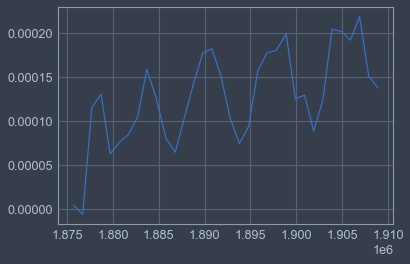

In [11]:

plt.plot(df.Timestamp , df.Power)